### Prediction using Echo State Networks (ESNs)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scipy.optimize
import sys
import warnings
from IPython.display import clear_output, display

from ESN import *
from utils import RMSE

np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)


In [2]:
# K input units
# N internal units
# L output units

# W_in   : N x K
# W      : N x N
# W_out  : L x (K + N + L)

# n      : nth time step
# u(n)   : activation of input units (K-dim)
# x(n)   : activation of internal units (state) (N-dim)
# y(n)   : activation of output units
# f      : internal unit output function (also referred to as activation function), typically a sigmoid function like tanh

# internal activation is updated by
# x(n+1) = f(W_in u(n+1) + W x(n))
#           f([Nx1] + [Nx1]) -> [Nx1]

# if using leaky integrator neurons:
# x(n+1) = (1-a)x(n) + a*f(W_in u(n+1) + W x(n))

# output computed by
# y(n+1) = f_out(W_out (u(n+1),x(n+1),y(n)))
#           f([Lx1]) -> []

# where (u(n+1),x(n+1),y(n)) is a concatenation

In [3]:
lorenz = np.loadtxt('./datasets/py-lorenz_RK4_100.csv', delimiter=",", dtype='float64')
lorenz_scaled = np.loadtxt('./datasets/py-lorenz-scaled_RK4_100.csv', delimiter=",", dtype='float64')

# data = lorenz[:,1:]
# target = lorenz[1:,1:]
data = lorenz_scaled[:,1:]
target = lorenz_scaled[1:,1:]

train_start=500
train_end=8000
test_start=train_end
test_end=10000

training_target = target[train_start:train_end]
test_target = target[test_start:]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

Parameter Search

In [5]:
# u_0_scale_grid = [0.02, 0.05, 0.10, 0.20, 0.50, 0.80]
# u_1_scale_grid = [0.02, 0.05, 0.10, 0.20, 0.50, 0.80]
# u_2_scale_grid = [0.02, 0.05, 0.10, 0.20, 0.50, 0.80]
# spectral_radius_grid = [0.80, 0.85, 0.90, 0.99, 1.05, 1.15, 1.25, 1.55]
spectral_radius_grid = [0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
leaking_rate_grid = [0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]
regularization_grid = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
connection_prob_grid = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20]

# try a gradient descent construct 

In [6]:
t_forward = test_end-test_start
trials = 3
total_scens = len(spectral_radius_grid)*len(leaking_rate_grid)*len(regularization_grid)*len(connection_prob_grid)*trials
internal_units = 100
model_arr = []
config_arr = []
rmse_arr = []
ctr = 0
for w in spectral_radius_grid:
    for x in leaking_rate_grid:
        for y in regularization_grid:
            for z in connection_prob_grid:
                config_arr.append([w,x,y,z])
                best_model = None
                best_rmse = None
                for i in range(trials):
                    model = ESNModel(
                        inputUnits = 3,
                        inputConnGen = lambda m, n : np.random.choice([-1,1], (m,n), p=[0.5, 0.5]),
                        # inputConnGen = lambda m, n : np.random.choice([0.2], (m,n), p=[1]),
                        internalUnits = internal_units,
                        internalConnGen = lambda m, n : np.random.choice([0,-1,1], (m,n), p=[1-z, z/2, z/2]),
                        outputUnits = 3,
                        leakRate = x,
                        spectralRadius = w,
                        regularization = y,
                        activation = np.tanh
                    )
                    model.train(data, target, train_indices)
                    recursive_out = model.recursive_predict(data[train_end-500:train_end], t_forward)
                    rmse = RMSE(recursive_out, test_target)
                    if i == 0:
                        best_model = model
                        best_rmse = rmse
                    elif rmse < best_rmse:
                        best_model = model
                        best_rmse = rmse
                    clear_output(wait=True)
                    print(f'done: scen {ctr}/{total_scens-1} ({100*ctr/(total_scens-1):.02f}%) |  w={w} x={x} y={y} z={z}  |  trial {i}  |  rmse={rmse}')
                    ctr += 1
                model_arr.append(best_model)
                rmse_arr.append(best_rmse)


done: scen 7937/7937 (100.00%) |  w=0.9 x=1.0 y=0.1 z=0.2  |  trial 2  |  rmse=0.6306256635980922


In [7]:
rmse_arr_np = np.array(rmse_arr)
best_idx = np.argmin(rmse_arr_np[~np.isnan(rmse_arr_np)])

In [8]:
best_idx

467

In [9]:
rmse_arr[best_idx]

0.27248674185425015

In [43]:
model = model_arr[best_idx]

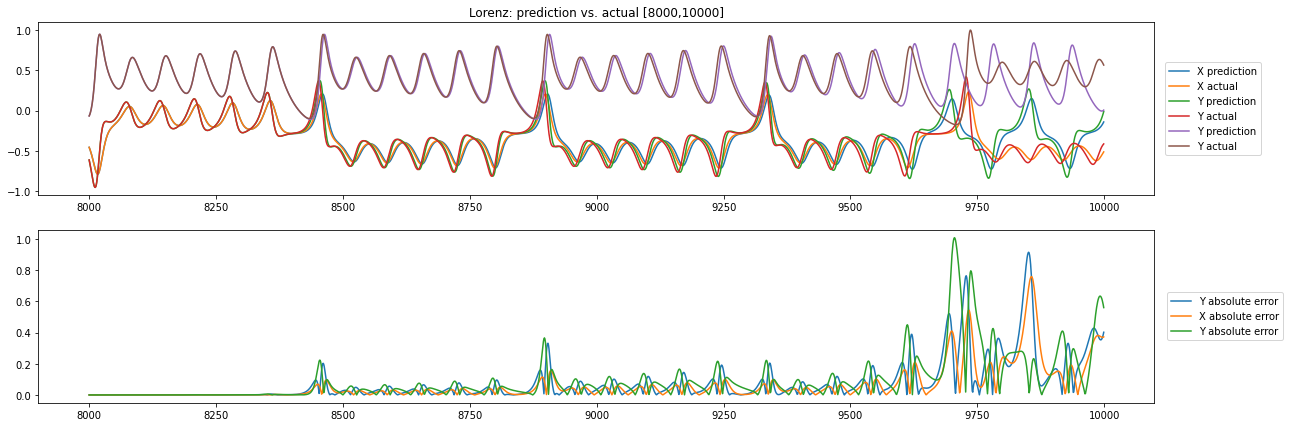

In [44]:
t_forward = test_end-test_start
# t_forward = 500

recursive_out = model.recursive_predict(data[train_end-500:train_end], t_forward)

data_end = train_end

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Y absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

In [14]:
print('best params')
print(f'spectral radius : {config_arr[best_idx][0]}')
print(f'leak rate       : {config_arr[best_idx][1]}')
print(f'regularization  : {config_arr[best_idx][2]}')
print(f'connection prob : {config_arr[best_idx][3]}')

best params
spectral radius : 0.4
leak rate       : 0.4
regularization  : 1e-07
connection prob : 0.2


In [48]:
model.trainingStates.shape

(7500, 100)

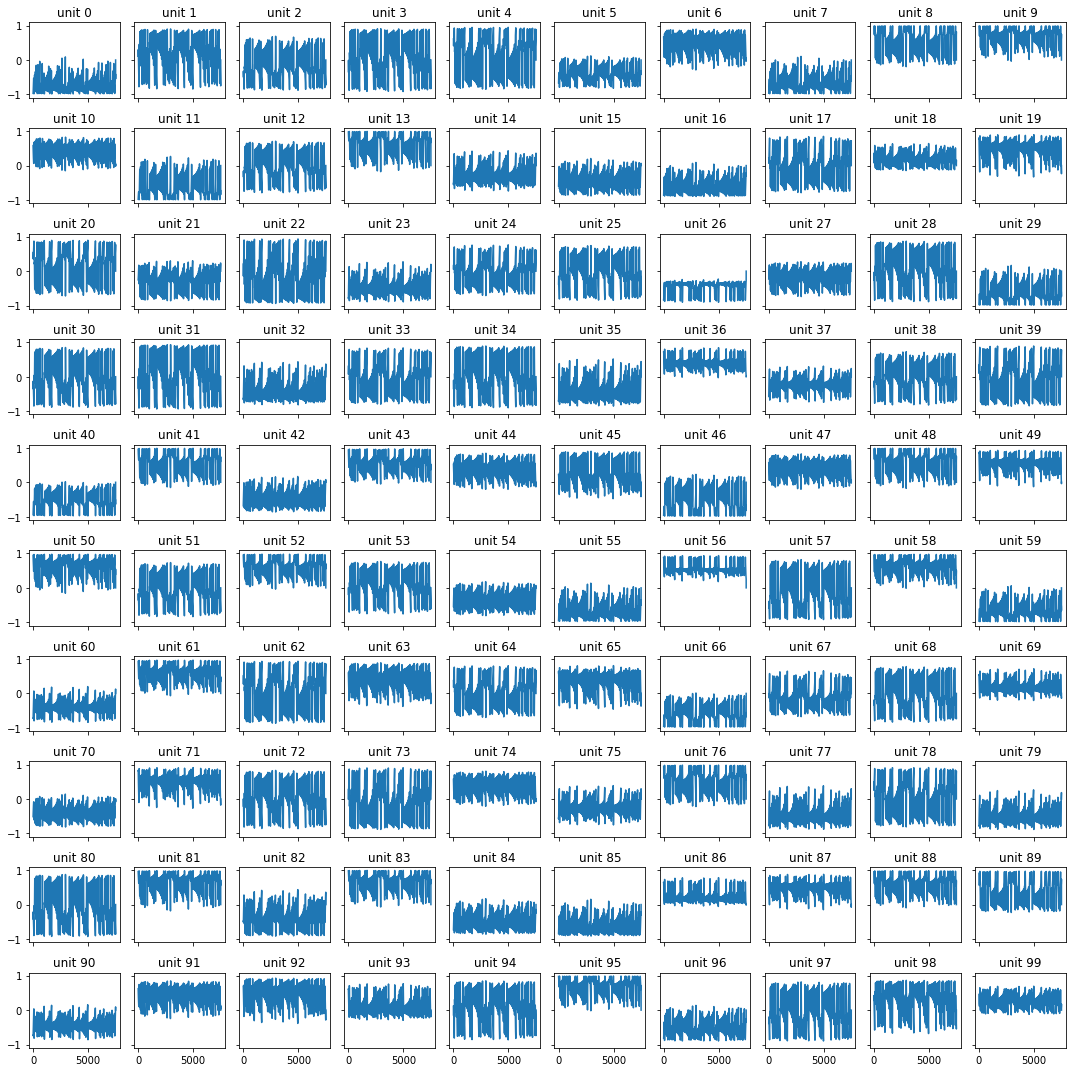

In [64]:
fig, axs = plt.subplots(10,10, figsize=(15,15), sharex=True, sharey=True)

for i in range(10):
    for j in range(10):
        axs[i,j].plot(np.arange(model.trainingStates.shape[0]), model.trainingStates[:,10*i+j])
        axs[i,j].set_title(f'unit {10*i+j}')
fig.tight_layout()
plt.show()

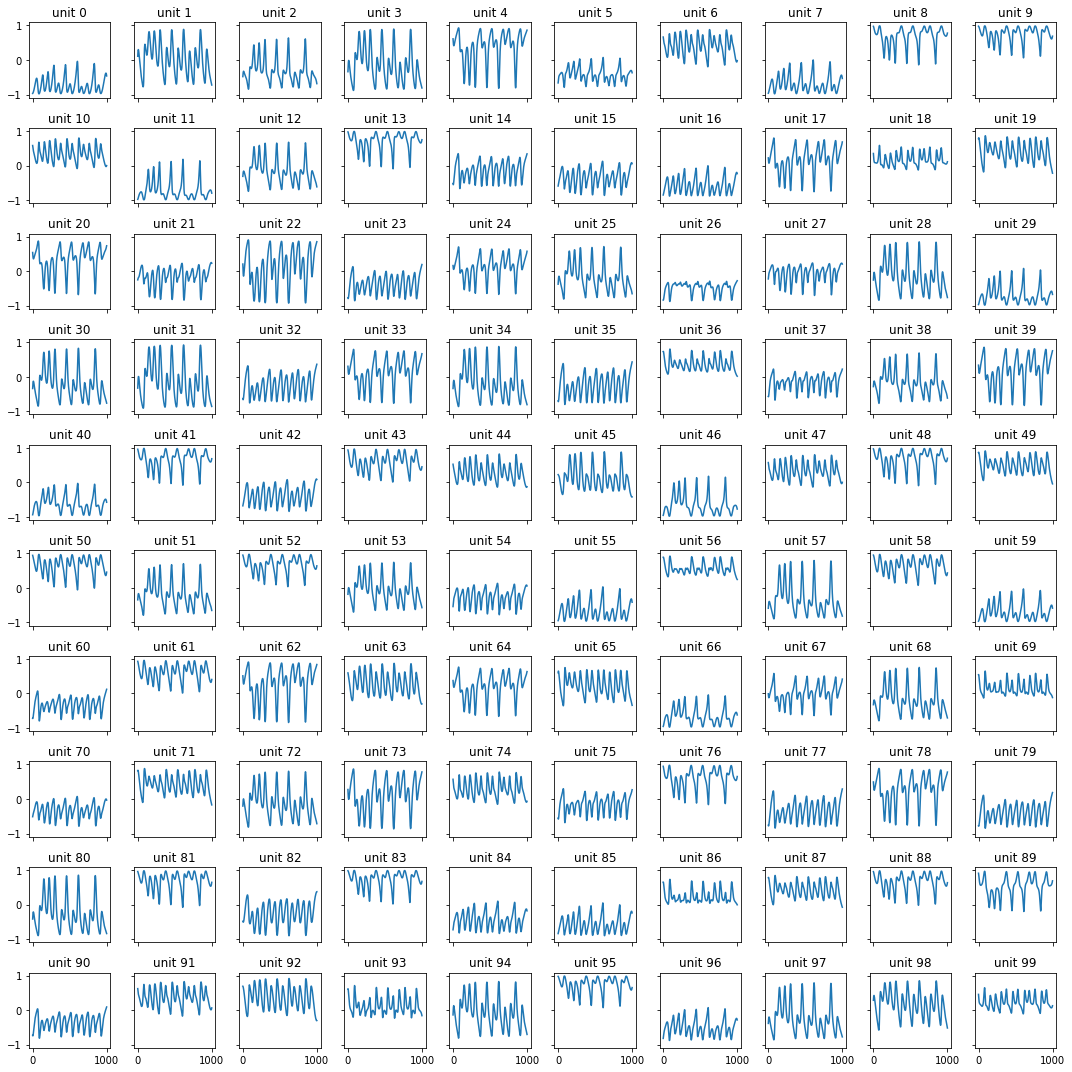

In [63]:
num_training_points = 1000

fig, axs = plt.subplots(10,10, figsize=(15,15), sharex=True, sharey=True)

for i in range(10):
    for j in range(10):
        axs[i,j].plot(np.arange(num_training_points), model.trainingStates[:num_training_points,10*i+j])
        axs[i,j].set_title(f'unit {10*i+j}')
fig.tight_layout()
plt.show()

Model random variation

In [15]:
trials = 100
RMSE_arr = np.zeros(trials)

sr = 0.4   # spectral radius
lr = 0.4   # leak rate
reg = 1e-7 # regularization
cp = 0.2   # connection prob

for i in range(trials):
    model = ESNModel(
        inputUnits = 3,
        inputConnGen = lambda m, n : np.random.choice([-1,1], (m,n), p=[0.5, 0.5]),
        internalUnits = 100,
        internalConnGen = lambda m, n : np.random.choice([0,-1,1], (m,n), p=[1-cp, cp/2, cp/2]),
        outputUnits = 3,
        leakRate = lr,
        spectralRadius = sr,
        regularization = reg,
        activation = np.tanh
    )
    model.train(data, target, train_indices)
    recursive_out = model.recursive_predict(data[train_end-500:train_end], len(test_indices))
    RMSE_arr[i] = RMSE(recursive_out, test_target)
    if (i+1)%10 == 0:
        print(f'done: i={i}')

done: i=9
done: i=19
done: i=29
done: i=39
done: i=49
done: i=59
done: i=69
done: i=79
done: i=89
done: i=99


In [36]:
min(RMSE_arr)

0.25787869340965935

In [21]:
capped_RMSE_arr = np.array([min(1,x) for x in RMSE_arr])

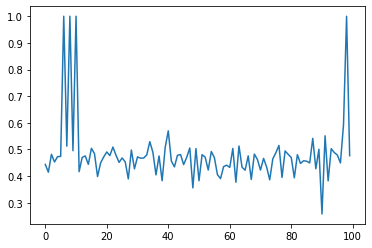

In [28]:
plt.plot(np.arange(len(capped_RMSE_arr)), capped_RMSE_arr)

(array([ 1., 14., 53., 26.,  2.,  0.,  0.,  0.,  0.,  4.]),
 array([0.25787869, 0.33209082, 0.40630295, 0.48051509, 0.55472722, 0.62893935, 0.70315148, 0.77736361, 0.85157574, 0.92578787, 1.        ]),
 <BarContainer object of 10 artists>)

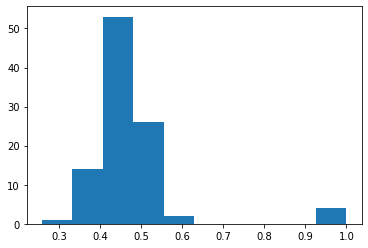

In [29]:
plt.hist(capped_RMSE_arr)

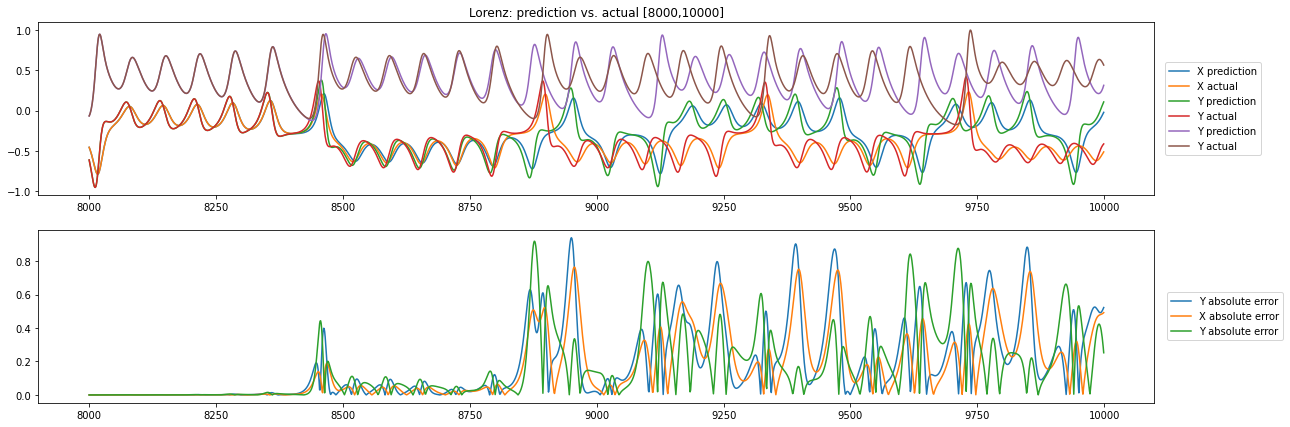

In [24]:
t_forward = test_end-test_start
# t_forward = 500

recursive_out = model.recursive_predict(data[train_end-500:train_end], t_forward)

data_end = train_end

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Y absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

Retry with 1000 model size

In [38]:
trials = 100
RMSE_arr_1000 = np.zeros(trials)

sr = 0.4   # spectral radius
lr = 0.4   # leak rate
reg = 1e-7 # regularization
cp = 0.2   # connection prob
size = 1000 # model size

for i in range(trials):
    model = ESNModel(
        inputUnits = 3,
        inputConnGen = lambda m, n : np.random.choice([-1,1], (m,n), p=[0.5, 0.5]),
        internalUnits = size,
        internalConnGen = lambda m, n : np.random.choice([0,-1,1], (m,n), p=[1-cp, cp/2, cp/2]),
        outputUnits = 3,
        leakRate = lr,
        spectralRadius = sr,
        regularization = reg,
        activation = np.tanh
    )
    model.train(data, target, train_indices)
    recursive_out = model.recursive_predict(data[train_end-500:train_end], len(test_indices))
    RMSE_arr_1000[i] = RMSE(recursive_out, test_target)
    if (i+1)%10 == 0:
        print(f'done: i={i}')

done: i=9
done: i=19
done: i=29
done: i=39
done: i=49
done: i=59
done: i=69
done: i=79
done: i=89
done: i=99


In [39]:
min(RMSE_arr_1000)

0.3548142654584545

In [40]:
capped_RMSE_arr_1000 = np.array([min(1,x) for x in RMSE_arr_1000])

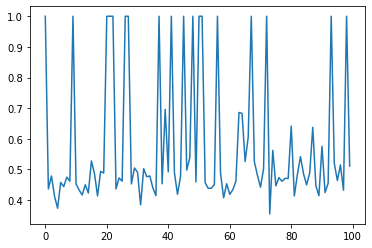

In [41]:
plt.plot(np.arange(len(capped_RMSE_arr_1000)), capped_RMSE_arr_1000)

(array([12., 41., 21.,  3.,  2.,  3.,  0.,  0.,  0., 18.]),
 array([0.35481427, 0.41933284, 0.48385141, 0.54836999, 0.61288856, 0.67740713, 0.74192571, 0.80644428, 0.87096285, 0.93548143, 1.        ]),
 <BarContainer object of 10 artists>)

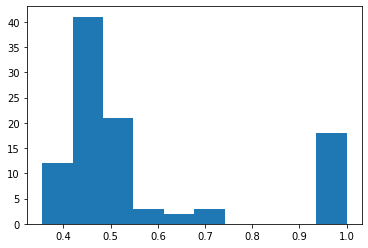

In [42]:
plt.hist(capped_RMSE_arr_1000)